In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, fbeta_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import defaultdict
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline


np.random.seed(42)  

data = pd.read_csv("data/TCGAdata.txt", sep=" ")
labels = pd.read_csv("data/TCGAlabels", sep=" ")


# Define classifiers
classifiers = [
    ("k-Nearest Neighbors (k=3)", KNeighborsClassifier, {"n_neighbors": 3}),
    ("Decision Tree", DecisionTreeClassifier, {"max_depth": 7}),
    ("k-Nearest Neighbors (k=30)", KNeighborsClassifier, {"n_neighbors": 30}),
]

num_principal_components = range(1, 20)

# scale the data for PCA
data = StandardScaler().fit_transform(data)

# scale data with min-max scaler for variance threshold
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(data)

all_results_pca = []
all_results_var = []

BETA = 5
cross_val_scoring = make_scorer(fbeta_score, beta=BETA, average="macro", response_method="predict", pos_label=None)

for test_size in [0.2]: #, 0.4, 0.8]:
    
    results = defaultdict(lambda: [])
    results_var = defaultdict(lambda: [])
    
    
    for name, classifier_class, params in classifiers:

        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=42)
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(scaled_data, labels, test_size=test_size, random_state=42)
        
        print(f"train size: {len(X_train)} ({(1 - test_size)*100}%) test size: {len(X_test)} ({(test_size)*100}%)")
        best_pca_score = 0
        best_pca_num_components = 0
        
        best_var_score = 0
        best_var_threshold = 0
        for num_compontents in num_principal_components:
            # Fit PCA
            pipeline = make_pipeline(PCA(n_components=num_compontents), classifier_class(**params))

            # Evaluate classifier
            # classifier = classifier_class(**params)
            scores = cross_val_score(pipeline, X_train , y_train.values.ravel(), cv=5, scoring=cross_val_scoring)
            results[name].append((1 - scores, num_compontents))
            scores = scores.mean()
            if scores > best_pca_score:
                best_pca_score = scores
                best_pca_num_components = num_compontents
        
        # re run with best parameters and compare cross-validation score, train score against test
        pca = PCA(n_components=best_pca_num_components)
        pca.fit(X_train)
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        classifier = classifier_class(**params)
        score = cross_val_score(classifier, X_train_pca, y_train.values.ravel(), cv=5, scoring=cross_val_scoring).mean()
        
        classifier.fit(X_train_pca, y_train.values.ravel())
        train_score = fbeta_score(y_train, classifier.predict(X_train_pca), average="macro", beta=BETA)
        test_score = fbeta_score(y_test, classifier.predict(X_test_pca), average="macro", beta=BETA)
        
        print(f"{name} with {best_pca_num_components} principal components: ")
        print("F SCORES:")
        print(f"Cross-validation error: {1 - score}, Train error: {1 - train_score}, Test error: {1 - test_score}")
        print()
        
        score = cross_val_score(classifier, X_train_pca, y_train.values.ravel(), cv=5).mean()

        classifier = classifier_class(**params)
        classifier.fit(X_train_pca, y_train.values.ravel())
        train_score = accuracy_score(y_train, classifier.predict(X_train_pca))
        test_score = accuracy_score(y_test, classifier.predict(X_test_pca))
        
        print("ACCURACY SCORES:")
        print(f"Cross-validation error: {1 - score}, Train error: {1 - train_score}, Test error: {1 - test_score}")
        print()
        
        
    all_results_pca.append((results, test_size))
    all_results_var.append((results_var, test_size))
        
    
    

    
    


In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, classifier.predict(X_test_pca))

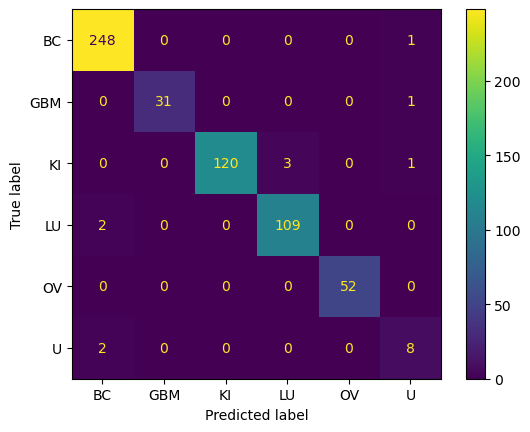

In [43]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, classifier.predict(X_test_pca))


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=classifier.classes_)
disp.plot()
